### Import Library


In [7]:
import os
import hashlib
import re
from collections import defaultdict
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet50, ResNet50_Weights
import time
from torch.autograd import Variable
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from torchsummary import summary

### Data Preparation

#### Data Atribute 

In [2]:
image_folder = './Images'
attribute_path = './list_attribute.txt'
with open(attribute_path, 'r') as f:
    lines = f.readlines()

header = lines[1].strip().split()
data_lines = lines[2:]

header

['5_o_Clock_Shadow',
 'Arched_Eyebrows',
 'Attractive',
 'Bags_Under_Eyes',
 'Bald',
 'Bangs',
 'Big_Lips',
 'Big_Nose',
 'Black_Hair',
 'Blond_Hair',
 'Blurry',
 'Brown_Hair',
 'Bushy_Eyebrows',
 'Chubby',
 'Double_Chin',
 'Eyeglasses',
 'Goatee',
 'Gray_Hair',
 'Heavy_Makeup',
 'High_Cheekbones',
 'Male',
 'Mouth_Slightly_Open',
 'Mustache',
 'Narrow_Eyes',
 'No_Beard',
 'Oval_Face',
 'Pale_Skin',
 'Pointy_Nose',
 'Receding_Hairline',
 'Rosy_Cheeks',
 'Sideburns',
 'Smiling',
 'Straight_Hair',
 'Wavy_Hair',
 'Wearing_Earrings',
 'Wearing_Hat',
 'Wearing_Lipstick',
 'Wearing_Necklace',
 'Wearing_Necktie',
 'Young']

In [4]:
data_lines[0]

'000001.jpg -1  1  1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1  1 -1  1 -1 -1  1 -1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1 -1  1\n'

#### Cek Jumlah Images

In [5]:
# Path folder gambar
img_dir = './Images' 

# Hitung jumlah file dengan ekstensi .jpg
jumlah_gambar = len([f for f in os.listdir(img_dir) if f.endswith('.jpg')])

print(f"Jumlah gambar dalam folder: {jumlah_gambar}")


Jumlah gambar dalam folder: 5017


### Cek Data Duplicated & Eleminate

In [8]:
# Dictionary: hash -> list of file names
hash_dict = defaultdict(list)

# Scan file dan hitung hash
for filename in os.listdir(img_dir):
    file_path = os.path.join(img_dir, filename)

    if not os.path.isfile(file_path):
        continue

    with open(file_path, 'rb') as f:
        file_hash = hashlib.md5(f.read()).hexdigest()

    hash_dict[file_hash].append(filename)

# Ambil file duplikat
duplikat_list = [file_list for file_list in hash_dict.values() if len(file_list) > 1]

if duplikat_list:
    print("\n=== Daftar File Duplikat ===\n")
    for file_list in duplikat_list:
        print("Duplikat:")
        for f in file_list:
            print(f" - {f}")
        print()

    hapus = input("Hapus file duplikat? (y/n): ")
    if hapus.lower() == 'y':
        for file_list in duplikat_list:
            # Cek file mana yang punya "(1)" atau pola seperti itu
            kandidat_dihapus = [f for f in file_list if re.search(r'\(\d+\)', f)]
            
            if kandidat_dihapus:
                # Jika ada yang mengandung (1), (2), dll → hapus semuanya kecuali yang tanpa tanda
                for f in kandidat_dihapus:
                    os.remove(os.path.join(img_dir, f))
                    print(f"File {f} dihapus.")
            else:
                # Kalau semuanya tanpa (1) → hapus salah satu saja (kecuali pertama)
                for f in file_list[1:]:
                    os.remove(os.path.join(img_dir, f))
                    print(f"File {f} dihapus.")

        print("\nSelesai menghapus file duplikat.")
    else:
        print("\nTidak ada file yang dihapus.")
else:
    print("\nTidak ada file duplikat yang ditemukan")

# Hitung ulang
jumlah_gambar = len([f for f in os.listdir(img_dir) if f.endswith('.jpg')])
print(f"\nJumlah gambar dalam folder: {jumlah_gambar}")


=== Daftar File Duplikat ===

Duplikat:
 - 182912(1).jpg
 - 182912.jpg

Duplikat:
 - 183121.jpg
 - 183121(1).jpg

Duplikat:
 - 182809.jpg
 - 182809(1).jpg

Duplikat:
 - 189513.jpg
 - 189513(1).jpg

Duplikat:
 - 189651(1).jpg
 - 189651.jpg

Duplikat:
 - 182943.jpg
 - 182943(1).jpg

Duplikat:
 - 183018.jpg
 - 183018(1).jpg

Duplikat:
 - 183050.jpg
 - 183050(1).jpg

Duplikat:
 - 189581(1).jpg
 - 189581.jpg

Duplikat:
 - 189132.jpg
 - 189132(1).jpg

Duplikat:
 - 182793.jpg
 - 182793(1).jpg

Duplikat:
 - 183145(1).jpg
 - 183145.jpg

Duplikat:
 - 189297.jpg
 - 189297(1).jpg

Duplikat:
 - 189324.jpg
 - 189324(1).jpg

Duplikat:
 - 183005.jpg
 - 183005(1).jpg

Duplikat:
 - 183111(1).jpg
 - 183111.jpg

Duplikat:
 - 189512(1).jpg
 - 189512.jpg



Hapus file duplikat? (y/n):  y


File 182912(1).jpg dihapus.
File 183121(1).jpg dihapus.
File 182809(1).jpg dihapus.
File 189513(1).jpg dihapus.
File 189651(1).jpg dihapus.
File 182943(1).jpg dihapus.
File 183018(1).jpg dihapus.
File 183050(1).jpg dihapus.
File 189581(1).jpg dihapus.
File 189132(1).jpg dihapus.
File 182793(1).jpg dihapus.
File 183145(1).jpg dihapus.
File 189297(1).jpg dihapus.
File 189324(1).jpg dihapus.
File 183005(1).jpg dihapus.
File 183111(1).jpg dihapus.
File 189512(1).jpg dihapus.

Selesai menghapus file duplikat.

Jumlah gambar dalam folder: 5000


### Ekstrak Label Male

In [9]:
# Path file atribut 
attr_path = './list_attribute.txt'

# Baca file atribut
attr_df = pd.read_csv(attr_path, sep='\s+', skiprows=1)

# Ubah label 'Male' dari -1/1 jadi 0/1
attr_df['Male'] = attr_df['Male'].apply(lambda x: 1 if x == 1 else 0)

print(attr_df[['Male']].head())

<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_566863/3693310954.py:5: SyntaxWarning: invalid escape sequence '\s'
  attr_df = pd.read_csv(attr_path, sep='\s+', skiprows=1)


            Male
000001.jpg     0
000002.jpg     0
000003.jpg     1
000004.jpg     0
000005.jpg     0


In [10]:
# Simpan ke CSV
attr_df[['Male']].reset_index().rename(columns={'index': 'images'}).to_csv('gender_classification.csv', index=False)

#### Cek Data Distribution

In [11]:
# Parsing data di list_attribute.txt
data = []
for line in data_lines:
    parts = line.strip().split()
    filename = parts[0]
    attributes = [int(x) for x in parts[1:]]
    data.append([filename] + attributes)

columns = ['filename'] + header
df_attributes = pd.DataFrame(data, columns=columns)

# Filter gambar yang ditemukan di image folder dan `filename` dari df_attributes
existing_files = []
for idx, row in df_attributes.iterrows():
    filename = row['filename']
    image_path = os.path.join(image_folder, filename)
    if os.path.exists(image_path):
        existing_files.append(idx)

df_attributes = df_attributes.iloc[existing_files].reset_index(drop=True) # Filter berdasarkan existing_files, reset index dan buang index lama

print(f"Total samples: {len(df_attributes)}")
print(f"Male count: {(df_attributes['Male'] == 1).sum()}")
print(f"Female count: {(df_attributes['Male'] == -1).sum()}")

Total samples: 5000
Male count: 2047
Female count: 2953


#### Filter Label dengan jumlah Image yang ada

In [12]:
# Cek folder
data_path = './'
os.listdir(data_path)

['gender_classification.csv',
 'Project 1.pdf',
 'pexels-fety-puja-amelia-1832324.jpg',
 'IMG_20200401_003602.jpg',
 'pexels-destiawan-nur-agustra-1028847.jpg',
 'Images',
 'GoogLeNet.ipynb',
 'ResNet50.ipynb',
 '.ipynb_checkpoints',
 'Images-20250529T094209Z-1-001.zip',
 'list_attribute.txt',
 'best_model.pth',
 'VGG19.ipynb']

In [13]:
images_list = os.listdir(os.path.join(data_path, 'Images'))

In [14]:
### Load data dari CSV
data = pd.read_csv(os.path.join(data_path, 'gender_classification.csv'))
print(data.columns)

Index(['images', 'Male'], dtype='object')


In [15]:
# Filter data dengan gambar yang ada
data = data[data['images'].isin(images_list)].reset_index(drop=True)
data

,images,Male
0,000051.jpg,1
1,000052.jpg,1
2,000065.jpg,1
3,000166.jpg,1
4,000198.jpg,0
...,...,...
4995,202320.jpg,0
4996,202340.jpg,0
4997,202347.jpg,0
4998,202357.jpg,0


In [16]:
# Split data 80:20
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

### Data Preprocessing


#### Data Augmentasi

In [17]:
class GenderDataset(Dataset):
    def __init__(self, data, image_folder_path, transform=None):
        self.data = data
        self.image_folder_path = image_folder_path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_folder_path, self.data.iloc[idx, 0])
        image = Image.open(image_path).convert('RGB')  # konversi ke RGB

        gender = self.data.iloc[idx, 1]  # pastikan kolom ke-1 adalah label (0/1)
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(gender, dtype=torch.long)

In [18]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

In [19]:
train_set = GenderDataset(train_data, image_folder_path=os.path.join(data_path, "Images"), transform=transform)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=2)

test_set = GenderDataset(test_data, os.path.join(data_path, "Images"), transform=transform)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False, num_workers=2)

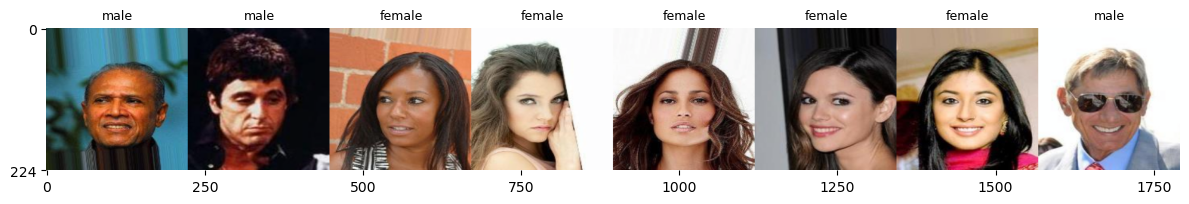

In [35]:
### Preview Data Augmentasi

import matplotlib.pyplot as plt
import numpy as np
import torch

def show_augmented_images(dataset, num_images=8):
    labels_map = {0: 'female', 1: 'male'}
    images = []
    labels = []

    for i in range(num_images):
        image, label = dataset[i]

        # Unnormalize
        image = image.permute(1, 2, 0).numpy()
        image = np.clip(
            image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]),
            0, 1
        )
        images.append(image)
        labels.append(labels_map[int(label)])

    # Gabungkan semua gambar horizontal
    combined = np.hstack(images)

    plt.figure(figsize=(12, 3))
    plt.imshow(combined)
    
    # Tambahkan label per gambar tepat di atasnya
    width_per_image = images[0].shape[1]
    for i, label in enumerate(labels):
        x = i * width_per_image + width_per_image // 2
        plt.text(x, -10, label, fontsize=9, color='black',
                 ha='center', va='bottom', rotation=0)

    # Ticks sumbu
    plt.xticks(np.arange(0, combined.shape[1], 250))
    plt.yticks([0, combined.shape[0]])

    plt.box(False)
    plt.tight_layout()
    plt.show()

show_augmented_images(train_set, num_images=8)


### Model Architecture


In [16]:
#model = resnet50(pretrained=True)
model = resnet50(weights=ResNet50_Weights.DEFAULT)

# Ganti classifier agar output = 2 class
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

#### Model Summary


In [42]:
print(model)
summary(model, input_size=(3, 224, 224))


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

###  Model Train

In [18]:
def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, use_gpu=torch.cuda.is_available(), num_epochs=10):
    since = time.time()
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            #for inputs, labels in dataloaders[phase]:
            for inputs, labels in tqdm(dataloaders[phase], desc=f"{phase} {epoch+1}/{num_epochs}"):
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), 'best_model.pth')

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    return model, history

In [19]:
dataloaders = {
    "train": train_loader,
    "test": test_loader
}

dataset_sizes = {
    "train": len(train_set),
    "test": len(test_set)
}

In [20]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    model = model.to("cuda")


In [21]:
model, history = train_model(model, dataloaders, dataset_sizes, criterion, optimizer, use_gpu, num_epochs=10)

Epoch 1/10
----------


train 1/10:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.2051 Acc: 0.9118


test 1/10:   0%|          | 0/32 [00:00<?, ?it/s]

test Loss: 0.4944 Acc: 0.8200
Epoch 2/10
----------


train 2/10:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.1234 Acc: 0.9543


test 2/10:   0%|          | 0/32 [00:00<?, ?it/s]

test Loss: 0.2677 Acc: 0.9450
Epoch 3/10
----------


train 3/10:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0694 Acc: 0.9730


test 3/10:   0%|          | 0/32 [00:00<?, ?it/s]

test Loss: 0.1198 Acc: 0.9590
Epoch 4/10
----------


train 4/10:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0723 Acc: 0.9743


test 4/10:   0%|          | 0/32 [00:00<?, ?it/s]

test Loss: 0.2396 Acc: 0.9120
Epoch 5/10
----------


train 5/10:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0545 Acc: 0.9790


test 5/10:   0%|          | 0/32 [00:00<?, ?it/s]

test Loss: 0.1025 Acc: 0.9700
Epoch 6/10
----------


train 6/10:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0424 Acc: 0.9848


test 6/10:   0%|          | 0/32 [00:00<?, ?it/s]

test Loss: 0.1490 Acc: 0.9550
Epoch 7/10
----------


train 7/10:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0470 Acc: 0.9815


test 7/10:   0%|          | 0/32 [00:00<?, ?it/s]

test Loss: 0.2112 Acc: 0.9410
Epoch 8/10
----------


train 8/10:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0430 Acc: 0.9853


test 8/10:   0%|          | 0/32 [00:00<?, ?it/s]

test Loss: 0.1056 Acc: 0.9630
Epoch 9/10
----------


train 9/10:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0285 Acc: 0.9903


test 9/10:   0%|          | 0/32 [00:00<?, ?it/s]

test Loss: 0.1612 Acc: 0.9570
Epoch 10/10
----------


train 10/10:   0%|          | 0/125 [00:00<?, ?it/s]

train Loss: 0.0280 Acc: 0.9903


test 10/10:   0%|          | 0/32 [00:00<?, ?it/s]

test Loss: 0.1427 Acc: 0.9620
Training complete in 3m 44s
Best val Acc: 0.9700


### Model Evaluation


In [37]:
from sklearn.metrics import ConfusionMatrixDisplay

def evaluate_model(model, test_loader, target_labels):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            if torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification Report
    print(classification_report(all_labels, all_preds, target_names=target_labels))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_labels)

    fig, ax = plt.subplots(figsize=(4,4))
    disp.plot(cmap='Blues', ax=ax, colorbar=False, values_format='d')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.grid(False)
    plt.show()


              precision    recall  f1-score   support

      female       0.95      0.98      0.97       596
        male       0.98      0.93      0.95       404

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000



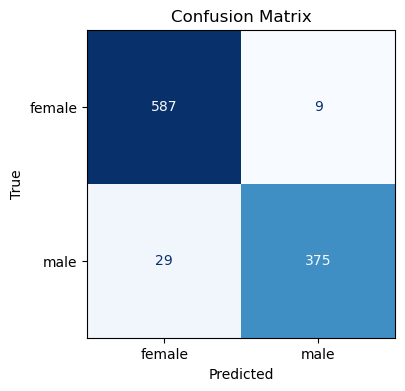

In [38]:
evaluate_model(model, dataloaders['test'], ["female", "male"])

#### Grafik akurasi dan loss per epoch

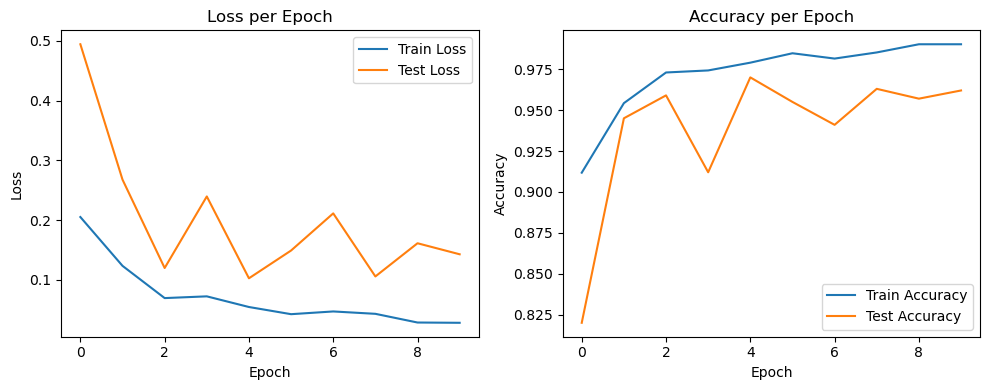

In [39]:
# Plot loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['test_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy')
plt.plot(history['test_acc'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.show()

### inference Images (Real-World Application)

In [40]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from IPython.display import display
import ipywidgets as widgets
import os

# Preprocessing yang sama dengan training
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Label nama class
class_names = ['female', 'male']

def infer_image(model, image_path):
    from PIL import Image
    import torchvision.transforms as transforms
    import torch.nn.functional as F

    # Tentukan device: gunakan CUDA kalau tersedia
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)  # Pindahkan model ke device

    # Preprocess image
    image = Image.open(image_path).convert('RGB')
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    input_tensor = transform(image).unsqueeze(0).to(device)  # Pindahkan input ke device

    # Inference
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        probs = F.softmax(outputs, dim=1)
        confidence, preds = torch.max(probs, 1)

    label_map = ['female', 'male']  # Contoh mapping label
    predicted_label = label_map[preds.item()]

    # Tampilkan hasil
    import matplotlib.pyplot as plt
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Predicted Label: {predicted_label}\nConfidence: {confidence.item():.2f}")
    plt.show()


def upload_and_infer(model):
    upload = widgets.FileUpload(accept='image/*', multiple=False)
    output = widgets.Output()

    def on_upload_change(change):
        output.clear_output()
        with output:
            # upload.value bisa tuple atau dict tergantung versi
            uploaded_files = upload.value
            if isinstance(uploaded_files, dict):  # ipywidgets lama
                uploaded_files = uploaded_files.items()
            elif isinstance(uploaded_files, tuple):  # ipywidgets baru
                uploaded_files = [(f['name'], f) for f in uploaded_files]

            for filename, fileinfo in uploaded_files:
                with open(filename, 'wb') as f:
                    f.write(fileinfo['content'])
                print(f"Saved {filename}")
                infer_image(model, filename)

    upload.observe(on_upload_change, names='value')
    display(widgets.VBox([upload, output]))

In [41]:
upload_and_infer(model)